In [121]:
#https://www.macroption.com/historical-volatility-calculation/
import json
import os
import requests
import warnings
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
import plotly.io as pio
from iexfinance.stocks import Stock, get_historical_data
from iexfinance import get_stats_recent
from fredapi import Fred
from pytradier import *
from options_ import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
if not os.path.exists('images'):
    os.mkdir('images')

In [151]:
with open('config.json') as f:
    data = json.load(f)
fred_key = data['fred']
tradier_key = data['tradier']
plotly_cred = data['plotly']

In [152]:
#FRED 
tradier = Tradier(tradier_key)
plotly.tools.set_credentials_file(username= plotly_cred['username'], api_key= plotly_cred['api-key'])
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')
fred = Fred(api_key=fred_key)

In [153]:
portfolio = ['MSFT', 'BA', 'AAPL', 'V', 'GOOGL', 'SPY']
stocks = Stock(portfolio)
p = stocks.get_price()
options_dates = [1, 3, 6, 9]

In [154]:
d = timedelta(days = 61)
yest = timedelta(days = 1)
start = date.today()-d
end = date.today()-yest
historicals = get_historical_data(portfolio, start, end, output_format='pandas').reset_index()
dates = historicals['date']

In [155]:
#Candlestick Graph
df = historicals[portfolio[0]].join(dates)
trace = go.Ohlc(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jaisal1024/0 or inside your plot.ly account where it is named 'simple_candlestick'


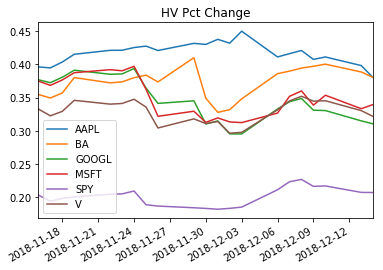

In [156]:
hv_1_df_ = hv_1(historicals, portfolio)
hv_1_df_.plot(title = 'HV Pct Change')

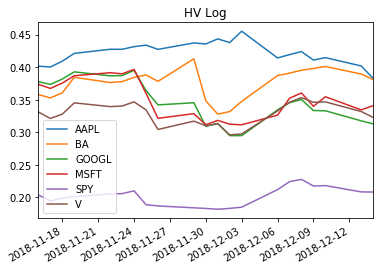

In [157]:
hv_2_df_ = hv_2(historicals, portfolio)
hv_2_df_.plot(title = 'HV Log')

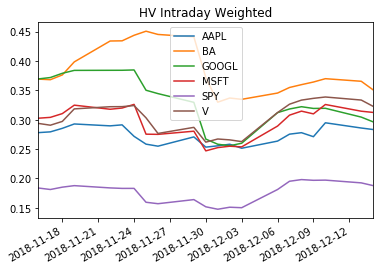

In [158]:
hv_weighted_df_ = hv_weighted(historicals, portfolio, 1)
hv_weighted_df_.plot(title = 'HV Intraday Weighted')

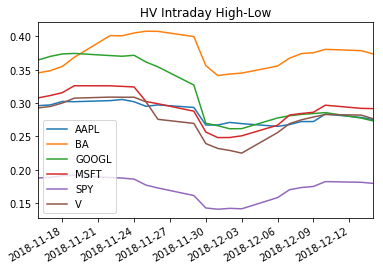

In [159]:
hv_hl_df_ = hv_hl(historicals, portfolio)
hv_hl_df_.plot(title = 'HV Intraday High-Low')

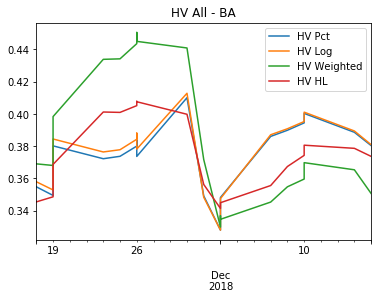

In [160]:
hv_all_ = hv_all('BA', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - BA')

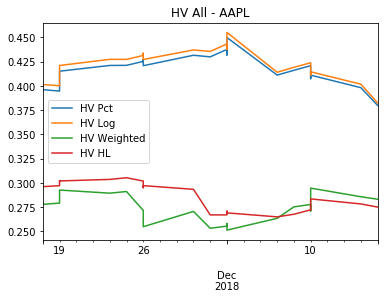

In [161]:
hv_all_ = hv_all('AAPL', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - AAPL')

In [188]:
def graph_option_1(chain, stock):
    chain_ = chain.loc[chain['Stock'] == stock]
    fig = plt.figure()
    ax = Axes3D(fig)
    Axes3D.mouse_init(ax)
    surf = ax.plot_trisurf(chain_["Strike"], chain_["T"], chain_["Call Premium"], cmap=cm.RdBu, linewidth=0.5, antialiased=False)
    ax.set_title('3-D Options Surface for '+ stock)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


def graph_option_subplot(chain, chain_2, stock, stock_2 = None): 
    if (stock_2 == None): 
        stock_2 = stock
    chain_ = chain.loc[chain['Stock'] == stock]
    chain_2 = chain.loc[chain['Stock'] == stock_2]
    
    x = chain_["Strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Call Premium"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["Strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Call Premium"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()
    
def graph_real_option_subplot(chain, stock): 
    chain_ = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'call'))]
    chain_2 = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'put'))]
    
    x = chain_["strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["spread"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()

### Each quarter, on the third Friday in March, June, September, and January*

In [163]:
t_exp = {}
for stock in portfolio:    
    t_exp[stock] = t_(date.today(), options_dates)

In [164]:
for stock in portfolio: 
    for i in range(len(t_exp[stock])): 
        while(not tradier.check_expiration(t_exp[stock][i], stock)): 
            print(stock, t_exp[stock][i])
            t_ = input()
            t_ = t_.split(',')
            t_ = date(int(t_[0]), int(t_[1]), int(t_[2]))
            t_exp[stock][i] = t_

BA 2019-03-15
2019,02,15
BA 2020-06-19
2021,01,15
V 2020-06-19
2021,01,15


In [165]:
r = list((fred.get_series('DGS1', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
q_matrix = extractQ(p, stocks)
strikes = strikes_(p, 5)
default = list((fred.get_series('BAMLH0A0HYM2', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
stats = stocks.get_key_stats()
beta = {}
for stock in portfolio:
    beta[stock] = stats[stock]['beta']

In [167]:
chains_blackscholes = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_blackscholes = pd.concat([chains_blackscholes, temp], ignore_index = True)  
            i+=1       

In [173]:
chains_extension = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2) * M_(.1, default, beta[stock], t), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2) * (1/M_(.1, default, beta[stock], t)), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_extension = pd.concat([chains_extension, temp], ignore_index = True)  
            i+=1  

In [34]:
chain_realtime = pd.DataFrame(columns = ['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type'])
for stock in portfolio: 
    for t in t_exp[stock]: 
        temp = tradier.get_option_chain(stock, t, "pandas")
        temp = temp[temp['strike'].isin(strikes[stock])]
        temp = temp[['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type']]
        chain_realtime = pd.concat([chain_realtime,temp])

In [35]:
chains_blackscholes

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
0,21.1279,2019-01-18,0.0342,MSFT,85.0,0.095890,106.03
1,16.2774,2019-01-18,0.1708,MSFT,90.0,0.095890,106.03
2,11.7261,2019-01-18,0.6066,MSFT,95.0,0.095890,106.03
3,7.7650,2019-01-18,1.6326,MSFT,100.0,0.095890,106.03
4,4.6624,2019-01-18,3.5172,MSFT,105.0,0.095890,106.03
5,2.5175,2019-01-18,6.3593,MSFT,110.0,0.095890,106.03
6,1.2188,2019-01-18,10.0478,MSFT,115.0,0.095890,106.03
7,0.5298,2019-01-18,14.3459,MSFT,120.0,0.095890,106.03
8,0.2077,2019-01-18,19.0109,MSFT,125.0,0.095890,106.03
9,0.0739,2019-01-18,23.8642,MSFT,130.0,0.095890,106.03


In [183]:
chains_extension

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
0,18.9904,2019-01-18,0.0322,MSFT,85.0,0.093151,106.03
1,14.6173,2019-01-18,0.1699,MSFT,90.0,0.093151,106.03
2,10.5037,2019-01-18,0.6285,MSFT,95.0,0.093151,106.03
3,6.9176,2019-01-18,1.7397,MSFT,100.0,0.093151,106.03
4,4.1136,2019-01-18,3.8183,MSFT,105.0,0.093151,106.03
5,2.1884,2019-01-18,6.9839,MSFT,110.0,0.093151,106.03
6,1.0380,2019-01-18,11.1079,MSFT,115.0,0.093151,106.03
7,0.4395,2019-01-18,15.9146,MSFT,120.0,0.093151,106.03
8,0.1669,2019-01-18,21.1244,MSFT,125.0,0.093151,106.03
9,0.0572,2019-01-18,26.5358,MSFT,130.0,0.093151,106.03


In [57]:
chain_realtime['spread'] = (chain_realtime['bid'] + chain_realtime['ask'])/2
chain_realtime['T']  = chain_realtime.loc[:,'expiration_date'].apply(lambda x: x.split('-')) 
chain_realtime['T']  = chain_realtime.loc[:,'T'].apply(lambda x: ((date(int(x[0]),int(x[1]),int(x[2]))-date.today()).days)/365) 

In [58]:
chain_realtime

,ask,bid,strike,underlying,volume,expiration_date,option_type,spread,T
44,0.27,0.18,85.0,MSFT,35,2019-01-18,put,0.225,0.095890
45,21.65,21.35,85.0,MSFT,12,2019-01-18,call,21.500,0.095890
48,0.48,0.40,90.0,MSFT,242,2019-01-18,put,0.440,0.095890
49,16.85,16.55,90.0,MSFT,146,2019-01-18,call,16.700,0.095890
52,12.35,12.05,95.0,MSFT,58,2019-01-18,call,12.200,0.095890
53,0.90,0.82,95.0,MSFT,1538,2019-01-18,put,0.860,0.095890
56,1.75,1.63,100.0,MSFT,3128,2019-01-18,put,1.690,0.095890
57,8.15,7.90,100.0,MSFT,184,2019-01-18,call,8.025,0.095890
58,3.35,3.15,105.0,MSFT,12306,2019-01-18,put,3.250,0.095890
59,4.70,4.50,105.0,MSFT,8174,2019-01-18,call,4.600,0.095890


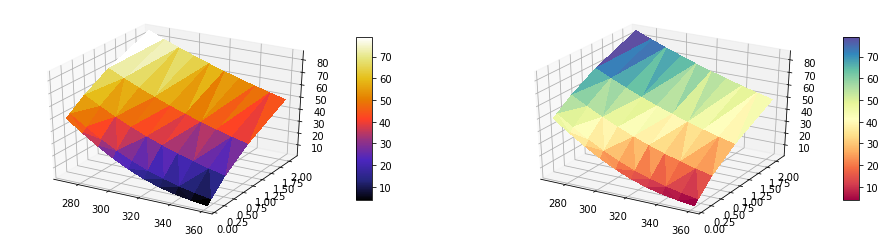

In [185]:
graph_option_subplot(chains_blackscholes, chains_extension, portfolio[1])

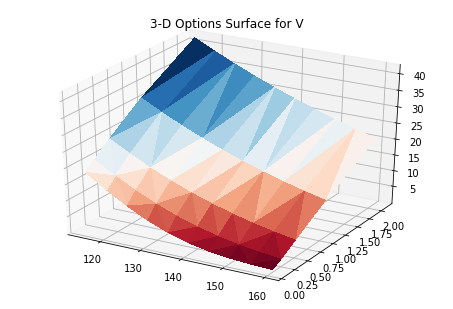

In [186]:
graph_option_1(chains_extension, portfolio[3])

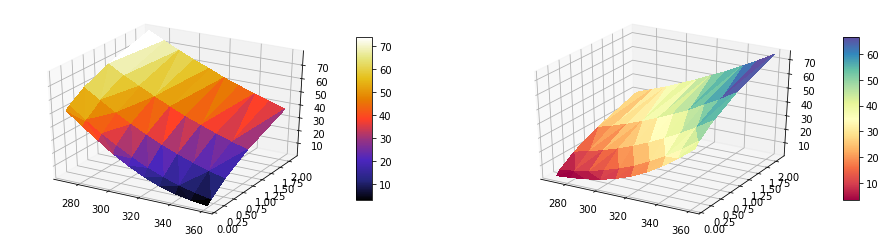

In [189]:
graph_real_option_subplot(chain_realtime, portfolio[1])

In [193]:
surface_graph_call = {}
for stock in portfolio: 
    temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
    temp2 = chains_blackscholes[(chains_blackscholes['Stock'] == stock)]
    temp3 = chains_extension[(chains_extension['Stock'] == stock)]
    x = temp['strike']
    y = temp['T']
    z = temp['spread']
    x1 = temp2['Strike']
    y1 = temp2['T']
    z1 = temp2['Call Premium']
    x2 = temp3['Strike']
    y2 = temp3['T']
    z2 = temp3['Call Premium']

    points2D = np.vstack([x,y]).T
    tri = Delaunay(points2D)
    simplices = tri.simplices

    points2D1 = np.vstack([x1,y1]).T
    tri1 = Delaunay(points2D1)
    simplices1 = tri1.simplices

    points2D2 = np.vstack([x2,y2]).T
    tri2 = Delaunay(points2D2)
    simplices2 = tri2.simplices

    fig = FF.create_trisurf(x=x, y=y, z=z,colormap=['rgb(56, 96, 56)', 'rgb(0, 39, 0)', ],
                             simplices=simplices, show_colorbar=False,
                             title=stock + " Call Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig2 = FF.create_trisurf(x=x1, y=y1, z=z1,colormap=['rgb(0, 155, 150)', 'rgb(105, 153, 255)', ],
                             simplices=simplices1, show_colorbar=False,
                             title=stock + " Call Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig3 = FF.create_trisurf(x=x2, y=y2, z=z2,colormap=['rgb(240, 128, 128)', 'rgb(139, 0, 0)', ],
                             simplices=simplices2, show_colorbar=False,
                             title=stock + " Call Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig["name"] = "Spread"
    fig2["name"] = "BS"
    fig3["name"] = "BS Extension"
    data = (fig, fig2, fig3)
    layout = go.Layout(
        title = stock + " Call Volatility Surface ",
        showlegend = True,
        scene = dict(
            xaxis = dict(
                title='Strike'),
            yaxis = dict(
                title='Time'),
            zaxis = dict(
                title='Premium'),))
        
    
    surface_graph_call[stock] = go.Figure(
        data = data,
        layout = layout)
    
    py.plot(surface_graph_call[stock], filename=stock+"CVolSurface")
    path = "images/" + stock + "CVolSurface.png"
#     pio.write_image(surface_graph_call[stock], path)

In [195]:
surface_graph_put = {}
for stock in portfolio: 
    temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'put'))]
    temp2 = chains_blackscholes[(chains_blackscholes['Stock'] == stock)]
    temp3 = chains_extension[(chains_extension['Stock'] == stock)]
    x = temp['strike']
    y = temp['T']
    z = temp['spread']
    x1 = temp2['Strike']
    y1 = temp2['T']
    z1 = temp2['Put Premium']
    x2 = temp3['Strike']
    y2 = temp3['T']
    z2 = temp3['Put Premium']

    points2D = np.vstack([x,y]).T
    tri = Delaunay(points2D)
    simplices = tri.simplices

    points2D1 = np.vstack([x1,y1]).T
    tri1 = Delaunay(points2D1)
    simplices1 = tri1.simplices

    points2D2 = np.vstack([x2,y2]).T
    tri2 = Delaunay(points2D2)
    simplices2 = tri2.simplices

    fig = FF.create_trisurf(x=x, y=y, z=z,colormap=['rgb(56, 96, 56)', 'rgb(0, 39, 0)', ],
                             simplices=simplices, show_colorbar=False,
                             title=stock + " Put Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig2 = FF.create_trisurf(x=x1, y=y1, z=z1,colormap=['rgb(0, 155, 150)', 'rgb(105, 153, 255)', ],
                             simplices=simplices1, show_colorbar=False,
                             title=stock + " Put Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig3 = FF.create_trisurf(x=x2, y=y2, z=z2,colormap=['rgb(240, 128, 128)', 'rgb(139, 0, 0)', ],
                             simplices=simplices2, show_colorbar=False,
                             title=stock + " Put Volatility Surface ", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3)).data[0]
    fig["name"] = "Spread"
    fig2["name"] = "BS"
    fig3["name"] = "BS Extension"
    data = (fig, fig2, fig3)
    layout = go.Layout(
        title = stock + " Put Volatility Surface ",
        showlegend = True,
        scene = dict(
            xaxis = dict(
                title='Strike'),
            yaxis = dict(
                title='Time'),
            zaxis = dict(
                title='Premium'),))
        
    
    surface_graph_put[stock] = go.Figure(
        data = data,
        layout = layout)
    
    py.plot(surface_graph_put[stock], filename=stock+"PVolSurface")
    path = "images/" + stock + "PVolSurface.png"
#     pio.write_image(surface_graph_call[stock], path)

In [192]:
plotly.io.orca.config.executable = '/Users/37138/anaconda3/lib/python3.6/site-packages/orca.app/Contents/MacOS/orca'
plotly.io.orca.config.save()

In [194]:
stock = 'GOOGL'
py.iplot(surface_graph_call[stock], filename=stock+"CVolSurface")

In [196]:
stock = 'GOOGL'
py.iplot(surface_graph_put[stock], filename=stock+"PVolSurface")

KeyboardInterrupt: 